In this notebook, I have used **[HuggingFace RoBERTa](https://https://huggingface.co/transformers/model_doc/roberta.html#robertaforsequenceclassification)** for predicting the product category.

In [26]:
pip freeze > requirements.txt # generating the requirements.txt file.

In [1]:
pip install torchtext==0.4

     |████████████████████████████████| 61kB 7.4MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
pip install transformers

     |████████████████████████████████| 2.2MB 19.2MB/s 
     |████████████████████████████████| 3.3MB 47.2MB/s 
     |████████████████████████████████| 870kB 38.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f9fef6962515a00c100b557a7d3ab7abe825f680be943829712e143ae7c21683
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

Loading the cleaned version of the original dataset. This dataset can be found  [here](https://drive.google.com/file/d/1uM5Kr_CieByJkZiSxVeKPhSpWV-aUYTY/view?usp=sharing).

In [27]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flipkart_ecommerce_processed_sample.csv', index_col = 0) # Reading the dataset

print("The data shape is:", df.shape) # shape of the dataset
df.head()

The data shape is: (19287, 4)


,product_name,brand,description,label
0,U. R. GOD Business / Visiting 10 Card Holder,U. R. GOD,key features of u r god business visiting 10 ...,"Bags, Wallets & Belts"
1,Dong Yang 880 Pouch Soccer Art Cloth Pencil Box,NaN,flipkart com buy dong yang 880 pouch soccer ar...,Toys & School Supplies
2,Shreya Collection 3 Multicolour Hair Clips Ban...,Shreya Collection,key features of shreya collection 3 multicolou...,Beauty and Personal Care
3,Jewel Paradise Brass Plated Brass Necklace,Jewel Paradise,jewel paradise brass plated brass necklace bu...,Jewellery
4,Disney Princess Cartoon Art Plastic Pencil Box,NaN,flipkart com buy disney princess cartoon art p...,Toys & School Supplies


Let's take a look at the different categories in the dataset.

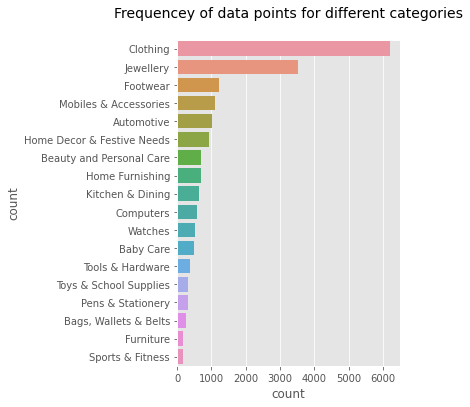


Total number of categories in the dataset -  18


In [28]:
value_counts = df.label.value_counts() # distinct categories in the dataset

all_categories = value_counts.to_frame('count')
all_categories['label'] = all_categories.index
all_categories = all_categories.reset_index(drop = True)

g = all_categories.nlargest(columns="count", n = 50) 
plt.figure(figsize=(4,6)) 
ax = sns.barplot(data=g, x= "count", y = "label") 
ax.set(ylabel = 'count') 
plt.title('Frequencey of data points for different categories\n', fontsize=14)
plt.show()

print("\nTotal number of categories in the dataset - ",len(value_counts)) # number of disctinct categories

Encoding The Labels

In [29]:
possible_labels = df.label.unique() # unique labels/categories in the dataset

label_dict = {}
for index, possible_label in enumerate(possible_labels): # creating a dictionary, label : encoded_value
    label_dict[possible_label] = index

print(label_dict)

df['labels'] = df['label'].map(label_dict) # encoding each unique label according to label_dict

{'Bags, Wallets & Belts': 0, 'Toys & School Supplies': 1, 'Beauty and Personal Care': 2, 'Jewellery': 3, 'Baby Care': 4, 'Clothing': 5, 'Mobiles & Accessories': 6, 'Automotive': 7, 'Footwear': 8, 'Pens & Stationery': 9, 'Watches': 10, 'Home Furnishing': 11, 'Sports & Fitness': 12, 'Home Decor & Festive Needs': 13, 'Tools & Hardware': 14, 'Computers': 15, 'Kitchen & Dining': 16, 'Furniture': 17}


In [30]:
df.head()

,product_name,brand,description,label,labels
0,U. R. GOD Business / Visiting 10 Card Holder,U. R. GOD,key features of u r god business visiting 10 ...,"Bags, Wallets & Belts",0
1,Dong Yang 880 Pouch Soccer Art Cloth Pencil Box,NaN,flipkart com buy dong yang 880 pouch soccer ar...,Toys & School Supplies,1
2,Shreya Collection 3 Multicolour Hair Clips Ban...,Shreya Collection,key features of shreya collection 3 multicolou...,Beauty and Personal Care,2
3,Jewel Paradise Brass Plated Brass Necklace,Jewel Paradise,jewel paradise brass plated brass necklace bu...,Jewellery,3
4,Disney Princess Cartoon Art Plastic Pencil Box,NaN,flipkart com buy disney princess cartoon art p...,Toys & School Supplies,1


Frequency of data points for a given length -

Average length of a product description -  68.71841136516825 




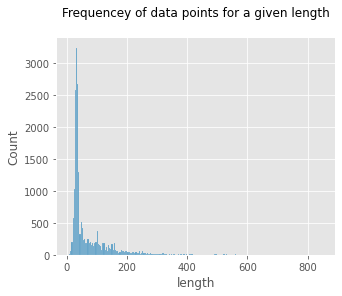

In [12]:
plt.style.use("ggplot")

plt.figure(figsize=(5, 4))
df['length'] = df['description'].apply(lambda x: len(x.split()))
sns.histplot(df['length'])
plt.title('Frequencey of data points for a given length\n', fontsize=12)
plt.xlabel('length', fontsize=12)
None

print("Average length of a product description - ", df.length.mean(), "\n\n")

In [31]:
# Setting the random seed
torch.manual_seed(17)


# set the device to GPU, if available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


To tokenize the data, we will be using **[RoBERTaTokenizer](https://https://huggingface.co/transformers/model_doc/roberta.html#robertatokenizer)** from HuggingFace.

In [32]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", padding = True) #initializing the tokenizer

Here, we have used various modules from [torchtext](https://https://torchtext.readthedocs.io/en/latest/data.html#dataset-batch-and-example) to define a [pre-processing](https://huggingface.co/transformers/preprocessing.html) pipeline for the data.

We have used RoBERTaTokenizer to tokenize the data, and split into train, test and validation set.

In [34]:
df.to_csv('dataset.csv')

# Setting the tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Defining Fields to be read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'description' : ('description', text_field), 'labels' : ('labels', label_field)}


# Split the dataset into train, test and validation sets
train_data, valid_data, test_data = TabularDataset(path=f"dataset.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='labels')

# Create train and validation iterators using BucketIterator from torchtext.data
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.description), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator without any shuffling
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

Functions for saving and loading model parameters and metrics.

In [16]:
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

We will use HuggingFace **[RobertaForSequenceClassification](https://huggingface.co/transformers/model_doc/roberta.html#robertaforsequenceclassification)** model for our purpose.

In [35]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                      num_labels=len(label_dict), # set number of labels according to our requirement
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [36]:
output_path = '/content/drive/My Drive/Colab Notebooks/' # to save the model

Training function -

In [38]:
def train(model, optimizer, train_iter, valid_iter, scheduler = None,
          num_epochs = 5, valid_period = len(train_iter), output_path = output_path):
    
    # Initializing losses
    train_loss = 0.0
    valid_loss = 0.0

    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # training loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:

            mask = (source != PAD_INDEX).type(torch.uint8)

            inputs = {
                      'input_ids':      source,
                      'labels':         target,
                      'attention_mask': mask
                     }      
            
            outputs = model(**inputs)
            loss = outputs[0]
            loss.backward() # calculate gradient
            
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad() # clear gradient
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:

                        mask = (source != PAD_INDEX).type(torch.uint8)

                        inputs = {
                        'input_ids':      source,
                        'labels':         target,
                        'attention_mask': mask
                        }     

                        outputs = model(**inputs)
                        
                        loss = outputs[0]
                        valid_loss += loss.item()

                # Store train and validation loss history

                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # Print the metrics
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # Model checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0            
                valid_loss = 0.0
                model.train() # back to train mode
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list) # saving the model metrics

Calling the train function to train the model.

In [21]:
steps_per_epoch = len(train_iter)
model = model.to(device)


NUM_EPOCHS = 5

print("Start training...")

optimizer = AdamW(model.parameters(), lr=2e-6, eps=1e-6, weight_decay=0.1) # defining optimizer
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS) # scheduler

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

print("Training done!!")

Start training...
Epoch [1/5], global step [1688/8440], Train Loss: 2.1753, Valid Loss: 1.6168
Epoch [2/5], global step [3376/8440], Train Loss: 1.0268, Valid Loss: 0.5995
Epoch [3/5], global step [5064/8440], Train Loss: 0.4503, Valid Loss: 0.2761
Epoch [4/5], global step [6752/8440], Train Loss: 0.2698, Valid Loss: 0.2073
Epoch [5/5], global step [8440/8440], Train Loss: 0.2124, Valid Loss: 0.1824
Training done!
Training done!!


Plotting the train and validation loss history.

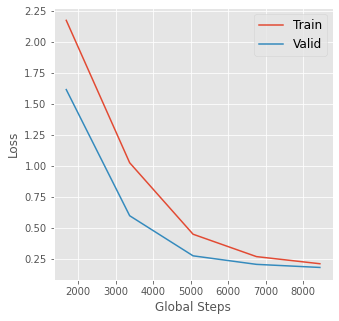

In [22]:
plt.figure(figsize=(5, 5))

train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')

plt.xlabel('Global Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.show() 

Evalution function

In [23]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:

                mask = (source != PAD_INDEX).type(torch.uint8)

                inputs = {
                        'input_ids':     source,
                        'labels':         target,
                        'attention_mask': mask
                        }     
                
                output = model(**inputs)

                y_pred.extend(torch.argmax(output[1], axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')


Testing the model on the test set, and printing out the metrics

In [24]:
# Initializing the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False, return_dict = False)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Classification Report:
              precision    recall  f1-score   support

           0     0.9074    0.9245    0.9159        53
           1     0.7000    0.8485    0.7671        66
           2     0.9514    0.9648    0.9580       142
           3     0.9901    0.9958    0.9929       706
           4     0.9213    0.8454    0.8817        97
           5     0.9943    0.9927    0.9935      1239
           6     0.9389    0.9773    0.9577       220
           7     0.9519    0.9802    0.9659       202
           8     1.0000    0.9959    0.9980       245
           9     0.8947    0.5397    0.6733        63
          10     1.0000    0.9906    0.9953       106
          11     0.8625    0.9857    0.9200       140
          12     0.8889    0.7273    0.8000        33
          13     0.9330    0.9731    0.9526       186
          14     0.9487    0.9487    0.9487        78
          15     0.9630    0.8966    0.9286       116
          16     0.9524    0.9302    0.9412       129
    

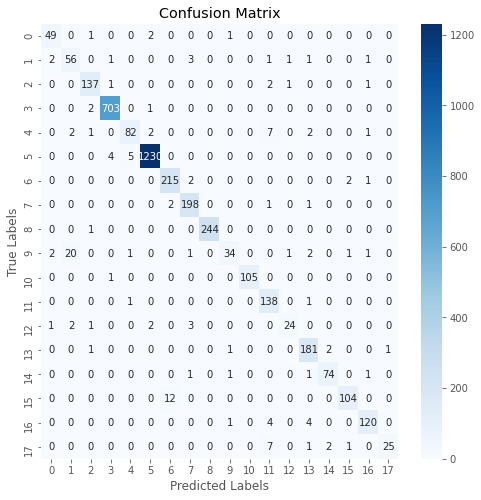

In [25]:
# Loading the saved model
load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter) # testing the model